# Instanciando pacotes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import yaml

from utils.transform_data import to_object, to_numeric, convert_sec_to_hour, remove_list_outliers
from utils.plotter import barplot_counts_cartola, barplot_grouped_cartola
from utils.drop_outliers import OutliersProcessor

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings("ignore")

# Carregamento dos dados

In [2]:
DATA_PATH = r'../data/01_raw/base_desafio_cartola.xlsx'

df_raw = pd.read_excel(DATA_PATH)
print('shape', df_raw.shape)
df_raw.head(3)

shape (50689, 1)


,"user,sexo,uf,idade,dias,pviews,visitas,tempo_total,device,futebol,futebol_intenacional,futebol_olimpico,blog_cartola,atletismo,ginastica,judo,natacao,basquete,handebol,volei,tenis,canoagem,saltos_ornamentais,home,home_olimpiadas,cartola_status"
0,"1912357,NA,NA,NA,12,31,20,3868.476999759674,pc..."
1,"1914630,NA,NA,NA,2,8,5,427.35199999809265,pc_o..."
2,"1915241,NA,NA,NA,14,44,23,14758.755000114441,p..."


## Organizando a estrutura do dataframe raw

In [3]:
# convertendo a primeira linha em uma lista com o nome de cada coluna
colunas = df_raw.columns[0].split(',')

# pegamos todas as linhas da primeira coluna do df e usamos list comprehension para fazer o split dos valores com vírgula
df_raw = pd.DataFrame([x.split(',') for x in df_raw.iloc[:, 0]]
                        , columns=colunas)
print('shape', df_raw.shape)
df_raw.head(3)

shape (50689, 26)


,user,sexo,uf,idade,dias,pviews,visitas,tempo_total,device,futebol,futebol_intenacional,futebol_olimpico,blog_cartola,atletismo,ginastica,judo,natacao,basquete,handebol,volei,tenis,canoagem,saltos_ornamentais,home,home_olimpiadas,cartola_status
0,1912357,NA,NA,NA,12,31,20,3868.476999759674,pc_e_m,0,0,45,0,90,2627.2339997291565,180.64800000190735,0,0,0,46.8510000705719,0,0,0,0,606.4270000457764,NÃ£o Cartola
1,1914630,NA,NA,NA,2,8,5,427.35199999809265,pc_only,201.33799982070923,45,45,0,0,0,0,0,0,0,45,0,0,0,0,0,NÃ£o Cartola
2,1915241,NA,NA,NA,14,44,23,14758.755000114441,pc_e_m,4867.996999979019,0,1331.5439999103546,0,1835.473000049591,0,972.9390001296997,90,0,2471.0930001735687,300.57299995422363,0,1956.6979999542236,431.6159999370575,0,91.72099995613098,NÃ£o Cartola


# Transformação

A transformação dos dados será embasada no objetivo da análise: identificação dos fatores e padrões que influenciam a propensão dos jogadores a se tornarem assinantes da versão pró do Cartola.

O  nosso objetivo é compreender o que motiva um usuário a aderir à versão premium do jogo, com o intuito de 
ampliar o engajamento e a receita relacionados ao Cartola.

In [4]:
df_transformed = df_raw.copy()

In [5]:
print('Shape do dataframe:', df_transformed.shape)
print('Usuários únicos:', df_transformed['user'].nunique())

Shape do dataframe: (50689, 26)
Usuários únicos: 50689


## Eliminando inconsistencias

## Conversão de valores

O dataframe irá passar por um pipeline que faz as seguintes conversões:

- colunas categóricas para object
- colunas numéricas para pd.to_numeric
- colunas com unidades em segundos para unidades em horas

In [6]:
cat_cols =  {
    'sexo': 'object'
    , 'uf': 'object'
    , 'cartola_status': 'object'
    , 'device': 'object'
    }

numeric_cols = [
    'idade'
    , 'dias'
    , 'pviews'
    , 'visitas'
    , 'tempo_total'
    , 'futebol'
    , 'futebol_intenacional'
    , 'futebol_olimpico'
    , 'blog_cartola'
    , 'atletismo'
    , 'ginastica'
    , 'judo'
    , 'natacao'
    , 'basquete'
    , 'handebol'
    , 'volei'
    , 'tenis'
    , 'canoagem'
    , 'saltos_ornamentais'
    , 'home'
    , 'home_olimpiadas'
]

cols_segundos = [
    'tempo_total'
    , 'futebol'
    , 'futebol_intenacional'
    , 'futebol_olimpico'
    , 'blog_cartola'
    , 'atletismo'
    , 'ginastica'
    , 'judo'
    , 'natacao'
    , 'basquete'
    , 'handebol'
    , 'volei'
    , 'tenis'
    , 'canoagem'
    , 'saltos_ornamentais'
    , 'home'
    , 'home_olimpiadas'
]


# Aplicando as funções usando o método pipe
df_transformed = (
    df_raw
    .pipe(to_object, cat_cols)
    .pipe(to_numeric, numeric_cols)
    .pipe(convert_sec_to_hour, cols_segundos)
)

Colunas relacionadas ao engajamento (agora em horas) de cada esporte serão transformadas em duas colunas:

- horas de engajamento em futebol
- horas de engajamento em outros esportes

Vamos isolar futebol para tentar identificar padrões de consumo de conteúdo de futebol nos clientes do dataset.

In [7]:

esportes_columns = [
    'atletismo'
    , 'ginastica'
    , 'judo'
    , 'natacao'
    , 'basquete'
    , 'handebol'
    , 'volei'
    , 'tenis'
    , 'canoagem'
    , 'saltos_ornamentais'
]

futebol_columns = [
    'futebol'
    , 'futebol_intenacional'
    , 'futebol_olimpico'
]

df_transformed['horas_engajamento_futebol'] = df_transformed[futebol_columns].sum(axis=1)
df_transformed['horas_engajamento_outros_esportes'] = df_transformed[esportes_columns].sum(axis=1)

df_transformed = df_transformed.drop(columns=esportes_columns)
df_transformed = df_transformed.drop(columns=futebol_columns)

Tempo na página 'home', independente se é a principal ou a home das olimpiadas serão unificados na coluna `horas_engajamento_home`

In [8]:
home_columns = [
    'home'
    , 'home_olimpiadas'
]

df_transformed['horas_engajamento_home'] = df_transformed[home_columns].sum(axis=1)
df_transformed = df_transformed.drop(columns=home_columns)

In [9]:
# verificando a estrutura do df até aqui
df_transformed.head(3)

,user,sexo,uf,idade,dias,pviews,visitas,tempo_total,device,blog_cartola,cartola_status,horas_engajamento_futebol,horas_engajamento_outros_esportes,horas_engajamento_home
0,1912357,NA,NA,NaN,12,31,20,1.074577,pc_e_m,0.0,NÃ£o Cartola,0.012500,0.817981,0.168452
1,1914630,NA,NA,NaN,2,8,5,0.118709,pc_only,0.0,NÃ£o Cartola,0.080927,0.012500,0.000000
2,1915241,NA,NA,NaN,14,44,23,4.099654,pc_e_m,0.0,NÃ£o Cartola,1.722095,2.238442,0.025478


O próximo passo é definir a estratégia para avaliar clientes cartola free e clientes cartola pro para atender o objetivo da análise:

- Clientes que não possuem cartola ou tem 'NA' não serão utilizados no dataframe.
- Isso ajuda a evitar distorções nos resultados e a focar em análises que realmente refletem o comportamento dos usuários que estão utilizando o serviço.

In [10]:
df_transformed['cartola_status'].unique()

array(['NÃ£o Cartola', 'Cartola Free', 'Cartola Pro', 'NA'], dtype=object)

In [11]:
# Substituindo os valores
df_transformed['cartola_status'] = df_transformed['cartola_status'].replace('NÃ£o Cartola', 'nao_cartola')
df_transformed['cartola_status'] = df_transformed['cartola_status'].replace('Cartola Free', 'cartola_free')
df_transformed['cartola_status'] = df_transformed['cartola_status'].replace('Cartola Pro', 'cartola_pro')
df_transformed['cartola_status'] = df_transformed['cartola_status'].replace('NA', 'sem_informacao')
df_transformed['cartola_status'].unique()

array(['nao_cartola', 'cartola_free', 'cartola_pro', 'sem_informacao'],
      dtype=object)

In [12]:
# vamos tirar pessoas que não tem informação sobre o cartola
df_transformed = df_transformed[df_transformed['cartola_status'] != 'sem_informacao']
df_transformed = df_transformed[df_transformed['cartola_status'] != 'nao_cartola']

Avaliando se sexo == 'NA' será removido ou não

In [13]:
# total de usuários únicos e total de usuários com 'NA'
total_users = df_transformed['user'].nunique()
na_sex_users = df_transformed[df_transformed['sexo'] == 'NA']['user'].nunique()

# percentual de representatividade de sexo == 'NA'
percent_na_sex = (na_sex_users / total_users) * 100
percent_na_sex

48.43833067517278

O percentual é alto, portanto, vamos avaliar individualmente a distribuição de cartola_status para essa variável

In [14]:
# Distribuição percentual de cartola_status na base total
base_comum = df_transformed['cartola_status'].value_counts(normalize=True) * 100

# Distribuição percentual de cartola_status para sexo = NA
base_na_sex = df_transformed[df_transformed['sexo'] == 'NA']['cartola_status'].value_counts(normalize=True) * 100

display(base_comum)
display(base_na_sex)

cartola_status
cartola_free    96.421451
cartola_pro      3.578549
Name: proportion, dtype: float64

cartola_status
cartola_free    98.175333
cartola_pro      1.824667
Name: proportion, dtype: float64

Devido ao alto percentual de representatividade e a distribuição parecer diferente quando avaliamos 'cartola_status', pode ser interessante manter esses registros para entendimento do comportamento dos usuários que não tem esse campo preenchido. Como alguns deles são usuários Pro, isso indica que o sexo não é o único fator que pode influenciar a adesão ao serviço. Ao manter esses registros, podemos explorar outras variáveis que possam impactar suas decisões.

In [15]:
# eliminando sexo desconhecido
# df_transformed = df_transformed[df_transformed['sexo'] != 'NA']

# eliminando linhas onde a idade é menor que 10 anos
df_transformed = df_transformed[(df_transformed['idade'] >= 10) & (df_transformed['idade'] <= 90) | (df_transformed['idade'].isna())]

print('Shape do dataframe:', df_transformed.shape)
print('Usuários únicos:', df_transformed['user'].nunique())

Shape do dataframe: (30023, 14)
Usuários únicos: 30023


## Lidando com outliers em métricas de engajamento


Processando coluna: pviews
Tamanho do DataFrame: 30023
Quantidade de outliers: 1464
Percentual de outliers: 4.88%
Outliers removidos (menos de 5% dos dados)


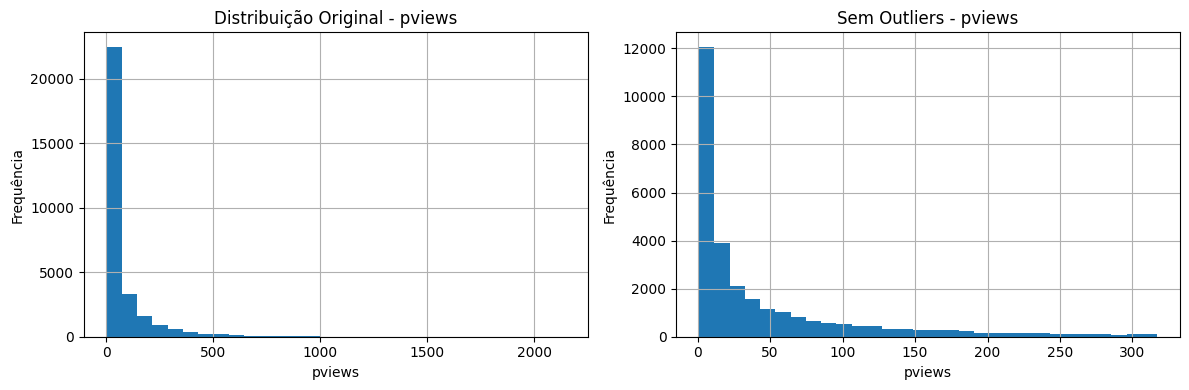


Processando coluna: visitas
Tamanho do DataFrame: 28559
Quantidade de outliers: 1646
Percentual de outliers: 5.76%
Alto percentual de outliers detectado


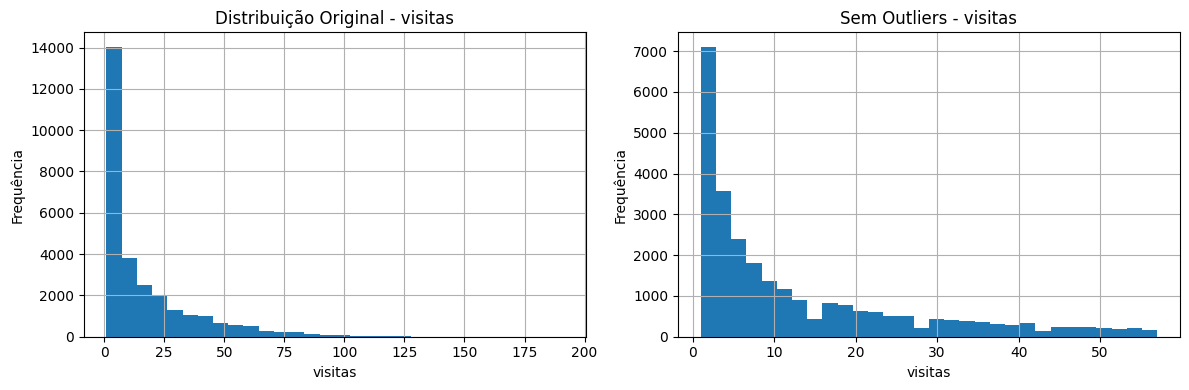


Processando coluna: tempo_total
Tamanho do DataFrame: 26913
Quantidade de outliers: 897
Percentual de outliers: 3.33%
Outliers removidos (menos de 5% dos dados)


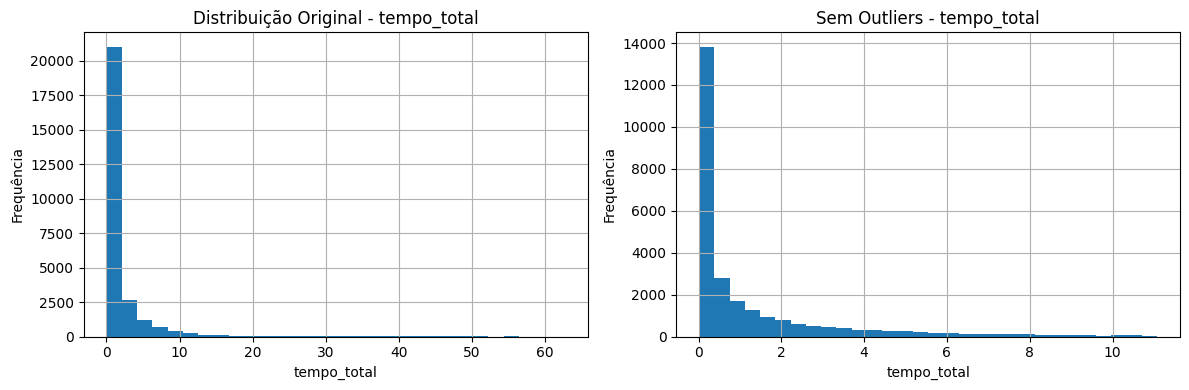


Processando coluna: blog_cartola
Tamanho do DataFrame: 26016
Quantidade de outliers: 978
Percentual de outliers: 3.76%
Outliers removidos (menos de 5% dos dados)


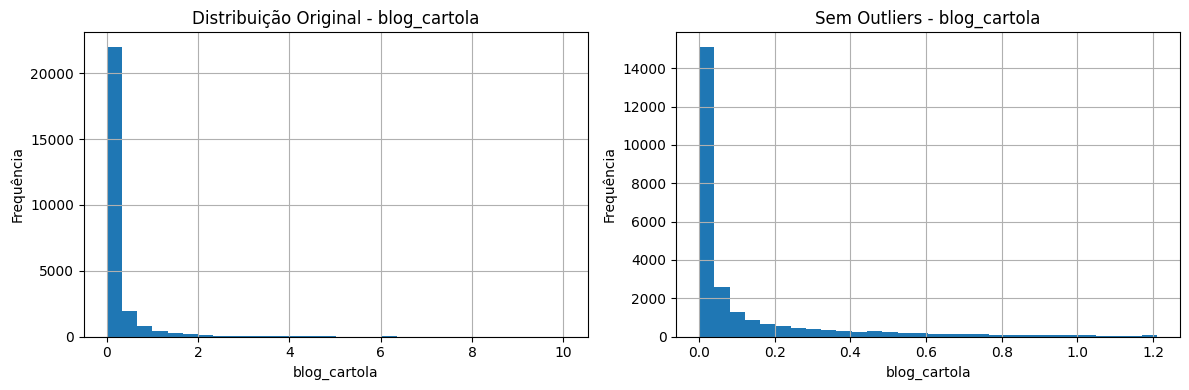


Processando coluna: horas_engajamento_home
Tamanho do DataFrame: 25038
Quantidade de outliers: 1106
Percentual de outliers: 4.42%
Outliers removidos (menos de 5% dos dados)


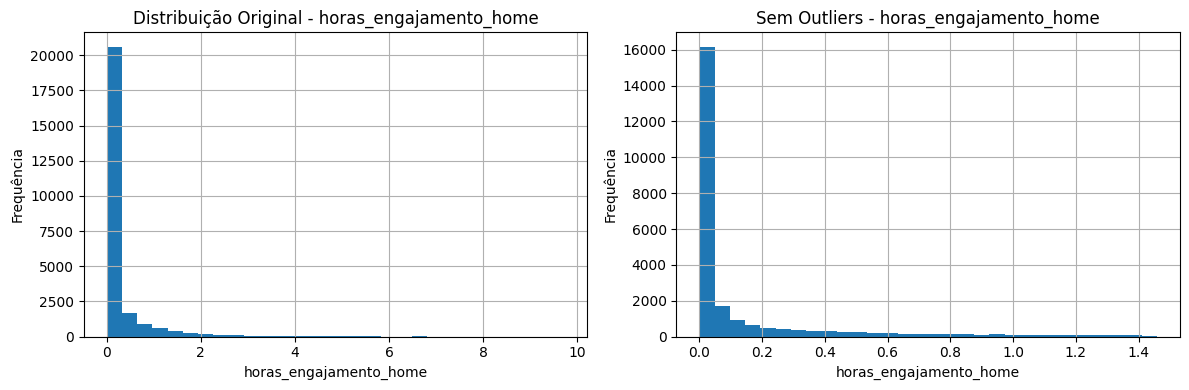


Processando coluna: horas_engajamento_futebol
Tamanho do DataFrame: 23932
Quantidade de outliers: 1190
Percentual de outliers: 4.97%
Outliers removidos (menos de 5% dos dados)


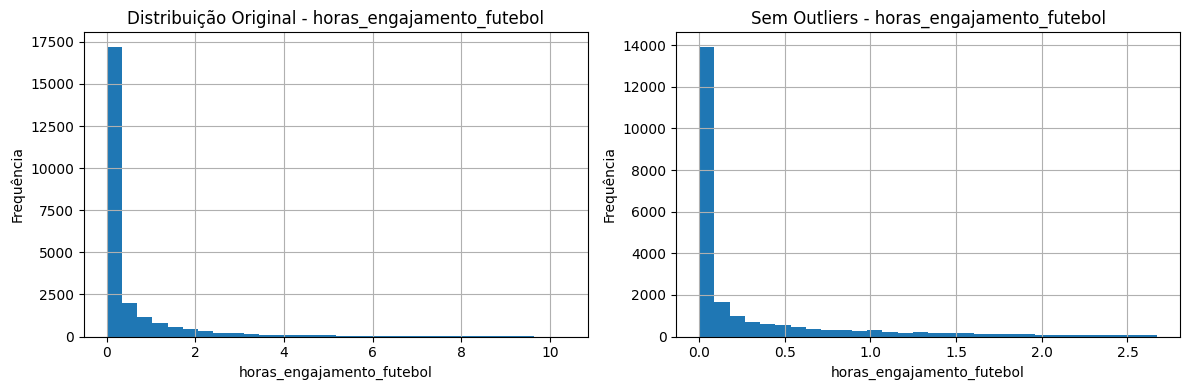

In [16]:
processor = OutliersProcessor(threshold=2, limite_percentual=5)
colunas = ['pviews', 'visitas', 'tempo_total', 'blog_cartola', 'horas_engajamento_home','horas_engajamento_futebol']
df_clean, resultados = processor.process_columns(df_transformed, colunas)

# Análise Exploratória

In [17]:
# percentual dos dados que serão utilizados após a limpeza
100 * df_clean.shape[0] / df_raw.shape[0]

44.86574996547574

In [18]:
df_clean['user'].nunique()

22742

In [19]:
df_clean['cartola_status'].value_counts()

cartola_status
cartola_free    22148
cartola_pro       594
Name: count, dtype: int64

In [20]:
df_clean['cartola_status'].value_counts(normalize=True).round(2) * 100

cartola_status
cartola_free    97.0
cartola_pro      3.0
Name: proportion, dtype: float64

## Sexo

In [21]:
# avaliando com NA's
fig = barplot_grouped_cartola(df_clean
                              , 'sexo'
                              , width=800
                              , height=500)

Para essa análise, vamos eliminar NA

In [22]:
fig = barplot_grouped_cartola(df_clean[df_clean['sexo'] != 'NA']
                              , 'sexo'
                              , theme=['#ec7b00', '#def7e5']
                              , width=800
                              , height=500)

## UF

In [23]:
top_10_uf = (
    df_clean['uf']
    .value_counts(ascending=False)[:10]
    .to_frame()
    .reset_index()
)

In [24]:
lista_top_10_uf = top_10_uf['uf'].unique()
lista_top_10_uf[:3]

array(['NA', 'Sao Paulo', 'Rio de Janeiro'], dtype=object)

In [25]:
df_top10_uf_free = df_clean.query(
    '(uf in @lista_top_10_uf) & (cartola_status == "cartola_free") & (uf != "NA")'
    )

barplot_counts_cartola(df_top10_uf_free, 'uf')

In [26]:
df_top10_uf_pro = df_transformed.query(
    '(uf in @lista_top_10_uf) & (cartola_status == "cartola_pro") & (uf != "NA")'
    )

barplot_counts_cartola(df_top10_uf_pro, 'uf')

## Idade

In [ ]:
from utils.transform_data import criar_faixas_etarias

df_com_faixas = criar_faixas_etarias(df_clean)

In [28]:
ordem_faixas = ['Até 17 anos', '18-25 anos', '26-35 anos', '36-45 anos', '46-60 anos', '60+ anos']
barplot_counts_cartola(
    df=df_com_faixas.query('cartola_status == "cartola_free"')
    , col='faixa_etaria'
    , title = 'Clientes Cartola Free'
    , xlabel='Quantidade'
    , ylabel='Faixa Etária'
    , width=500
    , height=450
    , order=ordem_faixas
    # , theme=px.colors.sequential.Greens_r
    , theme = ["#4fa748"] * 6
    )

In [29]:
barplot_counts_cartola(
    df=df_com_faixas.query('cartola_status == "cartola_pro"')
    , col='faixa_etaria'
    , title = 'Clientes Cartola Pro'
    , xlabel='Quantidade'
    , ylabel='Faixa Etária'
    , width=500
    , height=450
    , order=ordem_faixas
    , theme=['white', '#4fa748', '#4fa748', '#4fa748', 'white', 'white']
    )

## Engajamento

### Dias

In [30]:
import plotly.express as px

# Boxplot lado a lado
fig = px.box(
    df_clean,
    x='cartola_status',
    y='dias',
    color='cartola_status',
    color_discrete_sequence=['rgba(97, 168, 94, 0.7)', 'rgba(71, 136, 70, 1)'],
    width=500, height=400
)

fig.update_layout(
    title="Distribuição de Dias por Status do Cartola",
    xaxis_title="Status do Cartola",
    yaxis_title="Dias",
    legend_title_text='',
    template='plotly_white',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.25,
        xanchor='center',
        x=0.5
    )
)

fig.show()


### Visitas, Page Views e Horas de Navegação 

Vamos agrupar as variáveis para avaliar medidas de tendencia central

In [31]:
from scipy.stats import mannwhitneyu

def teste_hipoteses(df, col, alpha=0.05):
    """
    executa o teste estatístico apropriado para os dados.
    """
    
    # separando as variáveis em assinante e não assinante
    assinante = df[df['cartola_status'] == 'cartola_pro'][col]
    nao_assinante = df[df['cartola_status'] != 'cartola_pro'][col]

    # como as variáveis não seguem a distribuição normal, vamos utilizar o mannwhitneyu
    stat, p_valor = mannwhitneyu(assinante, nao_assinante)
    test_type = "Mann-Whitney U"
    
    print(f"p-valor: {p_valor}, Teste aplicado: {test_type}")
    
    return {"p_valor": p_valor, "teste": test_type}

In [32]:
for col in ['visitas', 'pviews', 'tempo_total', 'horas_engajamento_home']:
    print('Coluna:', col)
    
    df_teste_hipoteses = df_clean[df_clean[col] != 0]
    # eliminando valores diferentes de 0
    # pois 0 é a falta de engajamento na coluna avaliada
    teste_hipoteses(df_teste_hipoteses, col)
    
    display(
        df_teste_hipoteses
        .groupby(['cartola_status'])
        [col]
        .agg(['median', 'count'])
        )
    
    print()

Coluna: visitas
p-valor: 3.541315828545972e-30, Teste aplicado: Mann-Whitney U


,median,count
cartola_status,,
cartola_free,5.0,22148
cartola_pro,10.0,594



Coluna: pviews
p-valor: 1.1931937386607885e-37, Teste aplicado: Mann-Whitney U


,median,count
cartola_status,,
cartola_free,10.0,22148
cartola_pro,23.0,594



Coluna: tempo_total
p-valor: 2.245961950861747e-30, Teste aplicado: Mann-Whitney U


,median,count
cartola_status,,
cartola_free,0.186481,22148
cartola_pro,0.571223,594



Coluna: horas_engajamento_home
p-valor: 0.0025097815175816767, Teste aplicado: Mann-Whitney U


,median,count
cartola_status,,
cartola_free,0.075123,11105
cartola_pro,0.104970,398


**ANALISANDO POR FAIXA ETÁRIA**

In [33]:
df_com_faixas = df_com_faixas[df_com_faixas['idade'].notna()]

In [34]:
# dataframe vazio para armazenar os resultados
df_results_faixa_visitas = pd.DataFrame()

for faixa in df_com_faixas['faixa_etaria'].unique():
    df_filtro_faixa = df_com_faixas[df_com_faixas['faixa_etaria'] == faixa]
    
    quantidade_amostras_ = df_filtro_faixa['visitas'].count()
    mediana_visitas_ = df_filtro_faixa['visitas'].median()
    
    # criando um DataFrame com os resultados
    data_ = pd.DataFrame({
        'faixa_etaria': [faixa],
        'mediana_visitas': [mediana_visitas_],
        'quantidade_amostras': [quantidade_amostras_] 
    })
    
    # concatenando os resultados
    df_results_faixa_visitas = pd.concat([df_results_faixa_visitas, data_]
                                         , ignore_index=True)


df_results_faixa_visitas

,faixa_etaria,mediana_visitas,quantidade_amostras
0,46-60 anos,7.0,450
1,26-35 anos,7.0,4008
2,36-45 anos,7.0,1353
3,18-25 anos,6.0,4207
4,Até 17 anos,4.0,740
5,60+ anos,6.0,57


Criando coluna 'text' para informar os seguintes valores: (mediana visitas, número de amostras)

In [35]:
ordem_faixas = ['60+ anos', '46-60 anos', '36-45 anos', '26-35 anos', '18-25 anos', 'Até 17 anos']

# ordenando por faixa etária
df_results_faixa_visitas = (
    df_results_faixa_visitas
    .set_index('faixa_etaria')
    .reindex(ordem_faixas)
    .reset_index()
)


# Unindo a mediana de visitas com a quantidade de amostras
df_results_faixa_visitas['text'] = df_results_faixa_visitas.apply(
    lambda row: f"Mediana: {row['mediana_visitas']}, N: {row['quantidade_amostras']}", axis=1
)
df_results_faixa_visitas

,faixa_etaria,mediana_visitas,quantidade_amostras,text
0,60+ anos,6.0,57,"Mediana: 6.0, N: 57"
1,46-60 anos,7.0,450,"Mediana: 7.0, N: 450"
2,36-45 anos,7.0,1353,"Mediana: 7.0, N: 1353"
3,26-35 anos,7.0,4008,"Mediana: 7.0, N: 4008"
4,18-25 anos,6.0,4207,"Mediana: 6.0, N: 4207"
5,Até 17 anos,4.0,740,"Mediana: 4.0, N: 740"


In [36]:
# Definindo as cores das barras
colors_ = ['#e3f6e5'] * len(df_results_faixa_visitas)
colors_[2] = '#4fa748'
colors_[3] = '#4fa748'
colors_[4] = '#4fa748'

# Criando o gráfico
fig = px.bar(
    df_results_faixa_visitas,
    y='faixa_etaria',
    x='mediana_visitas',
    width=600,
    height=450,
    title='Mediana de Visitas por Faixa Etária: Planos Free e PRO',
    labels={'faixa_etaria': 'Faixa Etária', 'mediana_visitas': 'Mediana de Visitas'},
    template='plotly_white',
)

# Atualizando as cores das barras
fig.update_traces(marker_color=colors_, marker_line=dict(width=1, color='#4fa748'))

# Adicionando as anotações com estilo aprimorado
for i in range(len(df_results_faixa_visitas)):
    fig.add_annotation(
        x=df_results_faixa_visitas['mediana_visitas'].iloc[i],
        y=df_results_faixa_visitas['faixa_etaria'].iloc[i],
        text=df_results_faixa_visitas['text'].iloc[i],
        showarrow=True,
        arrowhead=2,
        ax=-80,
        ay=0,
        bgcolor='white',
        bordercolor='#d3d3d3',
        borderwidth=1,
        font=dict(color='black'),
    )

fig.update_layout(
    title_font=dict(size=18, color='#333'),                 # Tamanho e cor do título
    xaxis=dict(title_font=dict(size=14, color='#333')),     # Tamanho e cor do título do eixo x
    yaxis=dict(title_font=dict(size=14, color='#333')),     # Tamanho e cor do título do eixo y
    margin=dict(l=40, r=20, t=40, b=40),                    # Ajustando as margens
)


fig.show()


### Engajamento

In [37]:
def tempo_engajamento(df, col):
    # separando em df free e pro
    # pegando apenas dados de engajamento: col > 0
    df_free = df.loc[df['cartola_status'] == 'cartola_free'][[col]]
    df_free = df_free[df_free[col] > 0]

    df_pro = df.loc[df['cartola_status'] == 'cartola_pro'][[col]]
    df_pro = df_pro[df_pro[col] > 0]

    # calculando a mediana
    mediana_df_free = df_free[col].median()
    mediana_df_pro = df_pro[col].median()
    
    # transformando tempo em minutos
    mediana_free_min = mediana_df_free * 60
    mediana_pro_min = mediana_df_pro * 60

    # calculando a razao entre pro / free
    razao = mediana_df_pro / mediana_df_free

    print(f'Mediana Free: {mediana_free_min.round(2)} min')
    print(f'Mediana PRO: {mediana_pro_min.round(2)} min')
    print(f'Usuários PRO têm engajamento de {razao.round(1)}x mais minutos que o Free')

In [38]:
df_clean.head(2)

,user,sexo,uf,idade,dias,pviews,visitas,tempo_total,device,blog_cartola,cartola_status,horas_engajamento_futebol,horas_engajamento_outros_esportes,horas_engajamento_home
3,1919933,NA,NA,NaN,1,1,1,0.012500,m_only,0.012500,cartola_free,0.000000,0.0,0.00000
25,1979452,NA,NA,NaN,7,66,10,1.018757,pc_e_m,0.068122,cartola_pro,0.911605,0.0,0.02653


In [39]:
tempo_engajamento(df_clean, 'horas_engajamento_futebol')

Mediana Free: 8.18 min
Mediana PRO: 19.83 min
Usuários PRO têm engajamento de 2.4x mais minutos que o Free


In [40]:
tempo_engajamento(df_clean, 'horas_engajamento_outros_esportes')

Mediana Free: 2.66 min
Mediana PRO: 3.35 min
Usuários PRO têm engajamento de 1.3x mais minutos que o Free


In [41]:
tempo_engajamento(df_clean, 'horas_engajamento_home')

Mediana Free: 4.51 min
Mediana PRO: 6.3 min
Usuários PRO têm engajamento de 1.4x mais minutos que o Free


In [42]:
tempo_engajamento(df_clean, 'blog_cartola')

Mediana Free: 2.63 min
Mediana PRO: 4.83 min
Usuários PRO têm engajamento de 1.8x mais minutos que o Free


## Blog Cartola

In [43]:
# Criando rótulo para quem acessou o blog
df_clean.loc[df_clean['blog_cartola'] == 0 , 'acessou_blog_cartola'] = 0
df_clean.loc[df_clean['blog_cartola'] > 0 , 'acessou_blog_cartola'] = 1

In [44]:
# passando o campo para minutos
df_clean['blog_cartola_min'] = df_clean['blog_cartola'] * 60
df_clean['engajamento_futebol_min'] = df_clean['horas_engajamento_futebol'] * 60

In [45]:
nunca_acessaram_blog = (
    df_clean[df_clean['acessou_blog_cartola'] == 0]
    ['cartola_status']
    .value_counts(normalize=True).round(3) * 100
)

print('Usuários que nunca acessaram o blog cartola')
nunca_acessaram_blog

Usuários que nunca acessaram o blog cartola


cartola_status
cartola_free    97.9
cartola_pro      2.1
Name: proportion, dtype: float64

In [46]:
ja_acessaram_blog = (
    df_clean[df_clean['acessou_blog_cartola'] > 0]
    ['cartola_status']
    .value_counts(normalize=True).round(3) * 100
)

print('Usuários que ja acessaram o blog cartola')
ja_acessaram_blog

Usuários que ja acessaram o blog cartola


cartola_status
cartola_free    97.2
cartola_pro      2.8
Name: proportion, dtype: float64

In [47]:
# percentual dos usuários avaliados que nunca acessaram o blog catola
proporcao = (
    100 * 
    df_clean[df_clean['acessou_blog_cartola'] == 0]['user'].nunique() / 
    df_clean[df_clean['acessou_blog_cartola'] >  0]['user'].nunique()
)

proporcao.__round__(2)

34.62

**CONCENTRAÇÃO DE CLIENTES**

### Dispositivo

In [48]:
device_free = (
    df_clean[df_clean['cartola_status'] == 'cartola_free']
    ['device']
    .value_counts(normalize=True)
    .reset_index()
)


device_pro = (
    df_clean[df_clean['cartola_status'] == 'cartola_pro']
    ['device']
    .value_counts(normalize=True)
    .reset_index()
)

device_free['proportion'] = round( 100 * device_free['proportion'], 2 )
device_pro['proportion'] = round( 100 * device_pro['proportion'], 2 )

device_free['cartola_status'] = 'cartola_free'
device_pro['cartola_status'] = 'cartola_pro'

devices = pd.concat([device_free, device_pro])
devices.replace({'pc_only': 'apenas computador',
                 'pc_e_m': 'computador e mobile',
                 'm_only': 'apenas mobile'
                 }, inplace=True)
devices

,device,proportion,cartola_status
0,apenas mobile,43.76,cartola_free
1,apenas computador,34.40,cartola_free
2,computador e mobile,21.84,cartola_free
0,computador e mobile,44.44,cartola_pro
1,apenas computador,32.32,cartola_pro
2,apenas mobile,23.23,cartola_pro


In [49]:
px.bar(
    devices
    , x='device'
    , y='proportion'
    , color='cartola_status'
    , barmode='group'
    , text_auto='.3s'
    , width=800
    , color_discrete_sequence=['#d36c25', '#4fa748']
)